In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.stats import pearsonr, spearmanr

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [33]:
reward_df = pd.read_csv(
    "ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt100_numgenerations10_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv"
)
nll_df = pd.read_csv(
    "ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt100_numgenerations10_ancestral_t1.0_humanassistant_scorednll.csv"
)
assert reward_df[["prompt", "generated_text"]].equals(
    nll_df[["prompt", "generated_text"]]
)

In [34]:
df = reward_df.merge(nll_df, on=["prompt", "generated_text"])
df["generated_text"] = df.apply(
    lambda row: row["generated_text"][len(row["prompt"]) :], axis=1
)
df["log_probability"] = -df["negative_log_probability"]

df = df.drop_duplicates()
df.head()

,prompt,generated_text,score,score_text,negative_log_probability,negative_log_probability_text,log_probability
0,Human: Can you give me facts about jumping spiders?\n\nAssistant:,"ite a long distance. A typical jumping spider is 1-3 cm long and can jump 15-25 cm. In a jump, the spider first releases a silk line, which it wraps around its middle as it jumps. This gives it some stability and makes it easier to land after the jump. They’re very fast, and this is another reason why it’s so hard to catch them. When they’re under threat, jumping spiders will produce a cloud of foul-smelling chemicals from pores on their abdomen. It’s thought that this may be a deterrent to predators. Jumping spiders are an important source of food for many animals, including lizards, rodents, birds and spiders. They have large, forward-facing eyes, which help them to pinpoint their prey. They are generally a dark colour, but this can vary, from brown to reddish-brown. Most of them have",3.526157,"Human: Can you give me facts about jumping spiders?\n\n Assistant: Sure! Jumping spiders are called that because they can jump quite a long distance. A typical jumping spider is 1-3 cm long and can jump 15-25 cm. In a jump, the spider first releases a silk line, which it wraps around its middle as it jumps. This gives it some stability and makes it easier to land after the jump. They’re very fast, and this is another reason why it’s so hard to catch them. When they’re under threat, jumping spiders will produce a cloud of foul-smelling chemicals from pores on their abdomen. It’s thought that this may be a deterrent to predators. Jumping spiders are an important source of food for many animals, including lizards, rodents, birds and spiders. They have large, forward-facing eyes, which help them to pinpoint their prey. They are generally a dark colour, but this can vary, from brown to reddish-brown. Most of them have",386.109131,"Sure! Jumping spiders are called that because they can jump quite a long distance. A typical jumping spider is 1-3 cm long and can jump 15-25 cm. In a jump, the spider first releases a silk line, which it wraps around its middle as it jumps. This gives it some stability and makes it easier to land after the jump. They’re very fast, and this is another reason why it’s so hard to catch them. When they’re under threat, jumping spiders will produce a cloud of foul-smelling chemicals from pores on their abdomen. It’s thought that this may be a deterrent to predators. Jumping spiders are an important source of food for many animals, including lizards, rodents, birds and spiders. They have large, forward-facing eyes, which help them to pinpoint their prey. They are generally a dark colour, but this can vary, from brown to reddish-brown. Most of them have",-386.109131
1,Human: Can you give me facts about jumping spiders?\n\nAssistant:,"piders. They are distinguished from other spiders by the presence of large, membranous balloons on their abdomens, which they use for jumping. Their diets are mainly insects, although some are known to feed on other spiders or small vertebrates. They are extremely active during the day, when they hunt for prey. Most species are territorial and will attack and kill any intruder that enters their territory. They can be recognized by the presence of six large eyes, which give them a very wide field of view.",1.152493,"Human: Can you give me facts about jumping spiders?\n\n Assistant: The family Salticidae contains about 5,000 species of jumping spiders. They are distinguished from other spiders by the presence of large, membranous balloons on their abdomens, which they use for jumping. Their diets are mainly insects, although some are known to feed on other spiders or small vertebrates. They are extremely active during the day, when they hunt for prey. Most species are territorial and will attack and kill any intruder that enters their territory. They can be recognized by the presence of six large eyes, which give 

In [35]:
df[["score", "negative_log_probability", "log_probability"]].describe()

,score,negative_log_probability,log_probability
count,929.000000,929.000000,929.000000
mean,3.744077,140.191048,-140.191048
std,1.422366,102.761271,102.761271
min,-2.241594,6.657331,-533.626160
25%,2.870947,51.172031,-211.107208
50%,3.855331,118.304321,-118.304321
75%,4.664203,211.107208,-51.172031
max,9.513828,533.626160,-6.657331


In [38]:
num_corpuses = 1000

===== Sample level statistics =====
Spearman: SignificanceResult(statistic=0.40879929580520546, pvalue=9.889838795836128e-39)
Pearson: PearsonRResult(statistic=0.3173608933938588, pvalue=3.4947439607051306e-23)


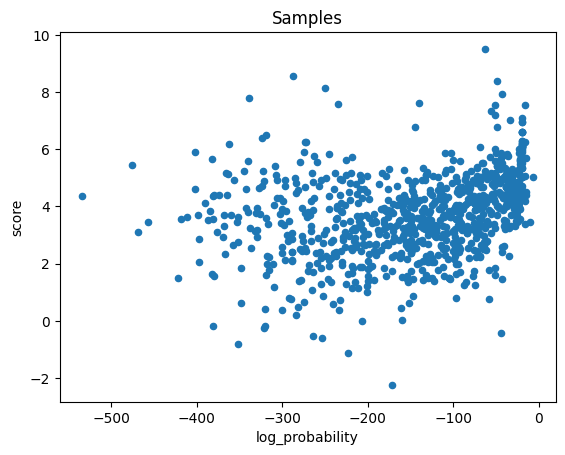

===== Corpus level statistics =====
Spearman: SignificanceResult(statistic=0.30481973712078947, pvalue=5.368614391666302e-108)
Pearson: PearsonRResult(statistic=0.3202712755188563, pvalue=1.2309518053921706e-119)


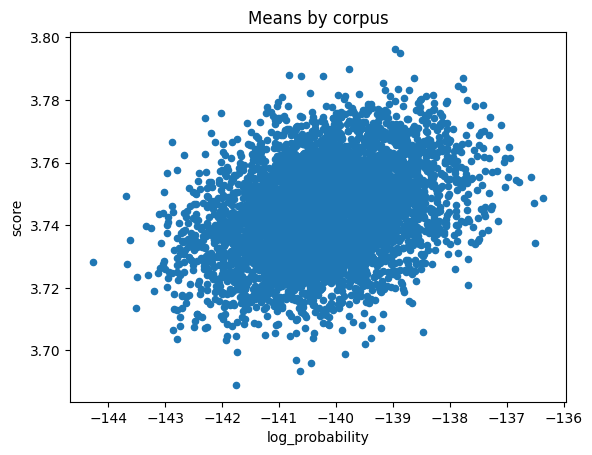

In [40]:
# Sample level statistics
print("===== Sample level statistics =====")
print(f"Spearman: {spearmanr(df['score'], df['log_probability'])}")
print(f"Pearson: {pearsonr(df['score'], df['log_probability'])}")
df.plot.scatter(y="score", x="log_probability", title="Samples")
plt.show()
plt.close()

# Corpus level
print("===== Corpus level statistics =====")
# 1. Sample corpuses
corpuses = {
    corpus_seed: df.sample(10 * len(df), random_state=corpus_seed, replace=True)
    for corpus_seed in range(num_corpuses)
}
mean_corpuses_df = pd.DataFrame.from_dict({
    corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
    for corpus_seed, corpus in corpuses.items()
}).T
print(
    "Spearman:"
    f" {spearmanr(mean_corpuses_df['score'], mean_corpuses_df['log_probability'])}"
)
print(
    "Pearson:"
    f" {pearsonr(mean_corpuses_df['score'], mean_corpuses_df['log_probability'])}"
)
mean_corpuses_df.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
)
plt.show()
plt.close()

Possible reasons: 
- is this method of resampling correct? 
- probability scoring might be wrong (do we include the prompt?) Prompt was included (but without the template, since generation was done without template)
- reward scoring might be wrong (do we include the prompt and prompt template)? Yes to both was done
- texts may have been sampled "poorly" - without the correct prompt template